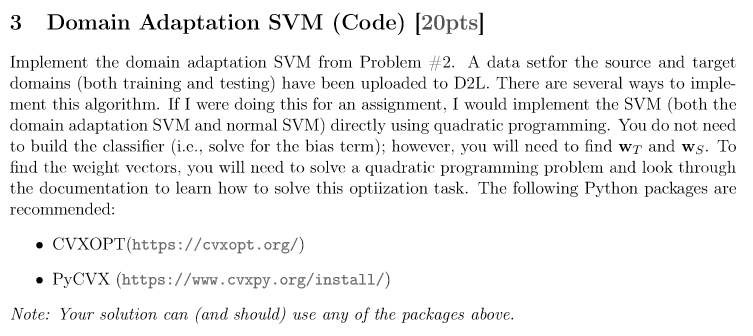

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets
import cvxopt as cx 
from sklearn import svm
from numpy import reshape

Using the following Quadratic Program

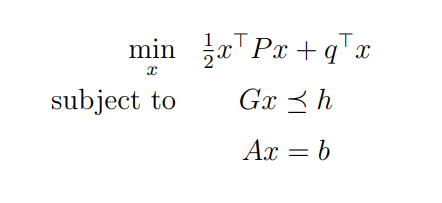

In [29]:
def split_dataset_np(source_dataset, target_dateset):
    """
    Input: two datasets
    Output: 4 dfs, x-,y-source, and x-,y-target
    """
    ysrc = source_dataset.iloc[:,-1].to_numpy()
    xsrc = source_dataset.iloc[:, 0:-1].to_numpy()
    
    ytar = target_dateset.iloc[:,-1].to_numpy()
    xtar = target_dateset.iloc[:, 0:-1].to_numpy()

    return xsrc,ysrc,xtar,ytar

def kernal_phi(x):
    '''
    Standard Linear Kernal function
    '''
    kx = np.array(np.dot(x,x.T))
    return kx

def qp_svm(x,y,C_reg,B_reg,ws):
    '''
    Quadratic Program SVM function: find weighted parameters to use for targeted data
    Solve the QP Terms (P,q, G, h, A, b)
    '''
    n = x.shape[0]

    #P = yi*yj*k(x,x) 
    P = np.outer(y,y) * kernal_phi(x)
    P = cx.matrix(P, tc="d")

    #q term -1 + ByiwsTx
    f1 = -1*np.ones(n)
    if B_reg > 0:
        for i in range(n):
            f1[i] = -1+B_reg*y[i]*np.dot(ws,x[i]) 
    q = cx.matrix(f1,tc="d")

    #A equaility term (Ax = b)
    A = cx.matrix(y, (1, n), tc="d")
    b = cx.matrix(0.0,tc="d")

    #G inequality term (Gx <= h)
    G = cx.matrix(np.vstack((np.diag(-1 * np.ones(n)),np.diag(np.ones(n)))),tc="d")
    h = cx.matrix(np.hstack((np.zeros(n),C_reg*np.ones(n))),tc="d")

    #alpha values
    sol = cx.solvers.qp(P,q, G, h, A, b)
    #alpha = np.ravel(sol["x"])
    alpha = sol["x"].T

    w = np.array([0.,0.])
    if B_reg > 0:
        w[0]= B_reg*ws[0] + np.sum(alpha*y*x[:,0])
        w[1]=B_reg*ws[1] + np.sum(alpha*y*x[:,1])

    else:
        w[0]=np.sum(alpha*y*x[:,0])
        w[1]=np.sum(alpha*y*x[:,1])
    print("\nC: %d, B: %d"%(C,B))
    print("Weights: ",w)
    print("\n")

    return w

def plot_svm(x,y,w,c):
    '''
    Plot the SVM Margin Lines against the Target Data to see how the cost 
    penality ajusts, as the weights do  
    '''
    plt.figure
   
    # fit the model
    clf = svm.SVC(kernel="linear", C=c)
    clf.fit(x, y)
    plt.scatter(x[:,0],x[:,1],c = y, cmap ='Dark2',edgecolors="k")

    # plot the decision function
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax1.contour(
        XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
    )
    # plot support vectors
    ax1.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=100,linewidth=1,facecolors="none",edgecolors="k")
    plt.title("Target Data ; C= %d"% c)
    plt.ylabel("x1")
    plt.xlabel("x0")
    plt.grid()
    plt.show()

In [6]:
source_path = "/content/drive/MyDrive/Git/ECE523/HW3/source_train.csv"
target_path = "/content/drive/MyDrive/Git/ECE523/HW3/target_train.csv"

source_ds = pd.read_csv(source_path, header=None)  
target_ds = pd.read_csv(target_path, header=None)  

     pcost       dcost       gap    pres   dres
 0: -5.4527e+01 -4.1324e+02  2e+03  3e+00  4e-15
 1: -3.5700e+01 -2.3871e+02  4e+02  3e-01  4e-15
 2: -2.5093e+01 -5.7172e+01  5e+01  3e-02  5e-15
 3: -2.5903e+01 -3.2574e+01  9e+00  6e-03  2e-15
 4: -2.7004e+01 -2.8976e+01  2e+00  1e-03  2e-15
 5: -2.7351e+01 -2.8080e+01  9e-01  4e-04  3e-15
 6: -2.7552e+01 -2.7690e+01  2e-01  6e-05  3e-15
 7: -2.7589e+01 -2.7628e+01  4e-02  1e-05  3e-15
 8: -2.7603e+01 -2.7607e+01  5e-03  1e-06  3e-15
 9: -2.7605e+01 -2.7605e+01  5e-05  1e-08  3e-15
10: -2.7605e+01 -2.7605e+01  5e-07  1e-10  3e-15
Optimal solution found.

C: 1, B: 0
Weights:  [1.92786559 1.82082169]


     pcost       dcost       gap    pres   dres
 0: -1.0443e+01 -1.1542e+02  7e+02  3e+00  4e-16
 1: -5.5520e+00 -6.7448e+01  1e+02  4e-01  4e-16
 2: -7.2201e-01 -1.2869e+01  2e+01  4e-02  2e-15
 3: -1.2286e+00 -2.6601e+00  2e+00  3e-03  7e-16
 4: -1.5711e+00 -1.8573e+00  3e-01  5e-04  2e-16
 5: -1.6714e+00 -1.6775e+00  7e-03  6e-06  3e-16

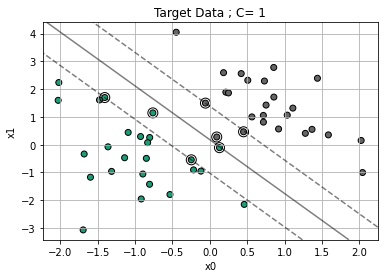

     pcost       dcost       gap    pres   dres
 0:  2.0578e+03 -3.1988e+05  9e+05  8e-01  2e-14
 1:  6.2843e+03 -7.7704e+04  1e+05  5e-02  5e-14
 2:  3.0741e+03 -7.4076e+03  1e+04  3e-03  3e-14
 3:  5.7636e+02 -8.0813e+02  1e+03  4e-05  1e-14
 4:  7.7728e+01 -9.6799e+01  2e+02  4e-15  6e-15
 5:  7.5585e+00 -3.8024e+01  5e+01  3e-14  2e-15
 6: -2.3555e+01 -3.6451e+01  1e+01  2e-14  2e-15
 7: -3.0006e+01 -3.0180e+01  2e-01  3e-14  3e-15
 8: -3.0097e+01 -3.0099e+01  2e-03  2e-14  2e-15
 9: -3.0098e+01 -3.0098e+01  2e-05  9e-16  2e-15
Optimal solution found.

C: 100, B: 1
Weights:  [8.4547185 6.0156039]




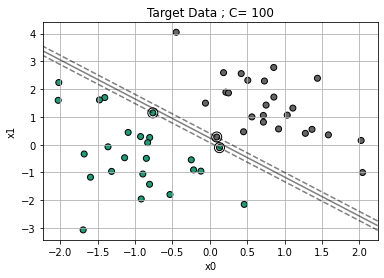

In [31]:
xsrc1,ysrc1,xtar,ytar = split_dataset_np(source_ds,target_ds)

C = 1
B = 0
# B=0, ws = np.sum(alph * y[i] * x[i])
ws = qp_svm(xsrc1,ysrc1,C,B,0)

B = 1
# B=1, wt = B*wt + np.sum(alph * y[i] * x[i])
wt = qp_svm(xtar,ytar,C,B,ws)
plot_svm(xtar,ytar,wt,C)

C=100
# B=1, wt = B*wt + np.sum(alph * y[i] * x[i])
wt = qp_svm(xtar,ytar,C,B,ws)
plot_svm(xtar,ytar,wt,C)

Note: As the cost increase, so do the weights